In [127]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import progressbar
from scipy import stats
import seaborn as sns

In [128]:
border = 160
dd = '../L3-L5_files'
exp = 'elev_bands'

In [129]:
fd = f'{dd}/{exp}/w5e5/qc0/pcpwin/match_geod_pergla/RGI62/b_{border:03d}/L3/summary/'
fs = glob.glob(fd+'glacier_statistics*.csv')
assert len(fs) == 19

df = []
for f in fs:
    df.append(pd.read_csv(f, index_col=0, low_memory=False))
df = pd.concat(df).sort_index()

In [130]:
df.iloc[0]

rgi_region                                              1
rgi_subregion                                       01-02
name                                                  NaN
cenlon                                           -146.823
cenlat                                             63.689
rgi_area_km2                                         0.36
rgi_year                                             2009
glacier_type                                      Glacier
terminus_type                            Land-terminating
is_tidewater                                        False
status                                 Glacier or ice cap
inv_volume_km3                                   0.007127
vas_volume_km3                                   0.008344
inv_volume_bsl_km3                                    0.0
inv_volume_bwl_km3                                    0.0
dem_source                                       COPDEM90
flowline_type                              elevation_band
apparent_mb_fr

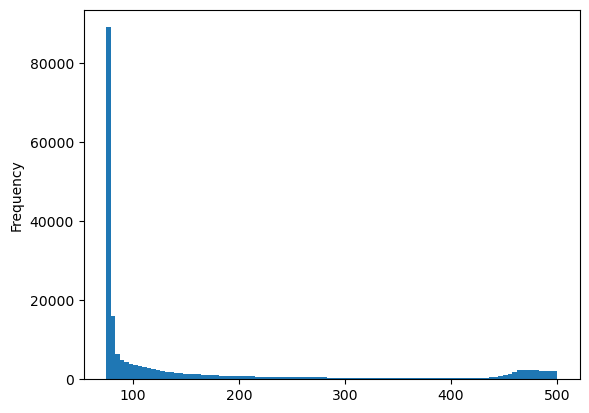

In [131]:
df.mu_star_glacierwide.plot(kind='hist', bins=100);

In [193]:
df.mu_star_glacierwide.min()

75.00005987953793

In [132]:
df.mu_star_glacierwide.median()

84.53368403870573

In [133]:
df.loc['RGI60-11.00897']

rgi_region                                             11
rgi_subregion                                       11-01
name                                      Hintereisferner
cenlon                                            10.7584
cenlat                                            46.8003
rgi_area_km2                                        8.036
rgi_year                                             2003
glacier_type                                      Glacier
terminus_type                            Land-terminating
is_tidewater                                        False
status                                 Glacier or ice cap
inv_volume_km3                                   0.638518
vas_volume_km3                                    0.59691
inv_volume_bsl_km3                                    0.0
inv_volume_bwl_km3                                    0.0
dem_source                                        NASADEM
flowline_type                              elevation_band
apparent_mb_fr

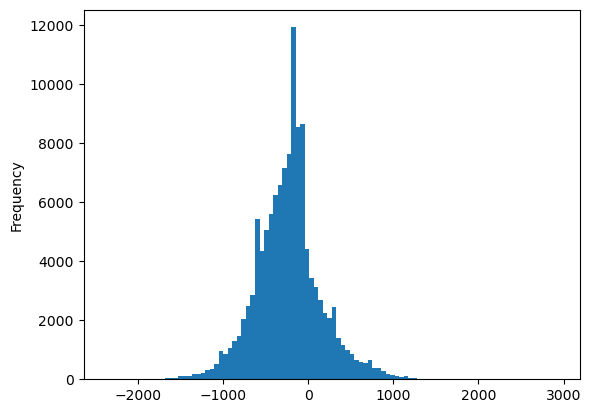

In [134]:
df.ref_hgt_calib_diff.plot(kind='hist', bins=100);

In [135]:
df.ref_hgt_calib_diff.isnull().sum()

93755

In [136]:
df_sel = df.loc[df.ref_hgt_calib_diff.isnull()]

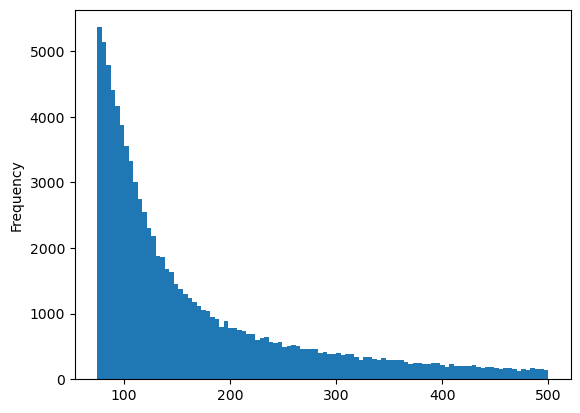

In [137]:
df_sel.mu_star_glacierwide.plot(kind='hist', bins=100);

In [138]:
df_sel.mu_star_glacierwide.median()

127.85672267724976

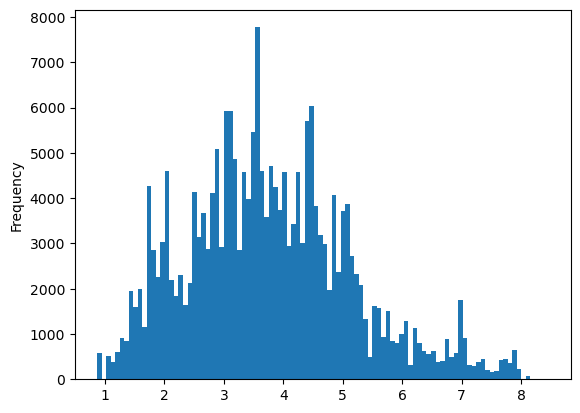

In [139]:
df.glacier_prcp_scaling_factor.plot(kind='hist', bins=100);

In [54]:
f = '/home/www/oggm/climate/gswp3-w5e5/unflattened/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019.nc'
with xr.open_dataset(f) as dse:
    dse = dse.resample(time='AS').mean(dim='time')

In [56]:
dse

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, time: 119)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2019-01-01
Data variables:
    tas      (time, lat, lon) float32 254.3 254.3 254.3 ... 226.8 226.8 226.8

In [58]:
weight = np.cos(np.deg2rad(dse.lat))
weight = weight / weight.sum()
era_ts = (dse.tas.mean(dim='lon') * weight).sum(dim='lat')
era_ts = era_ts.to_series()
era_ts.index = era_ts.index.year

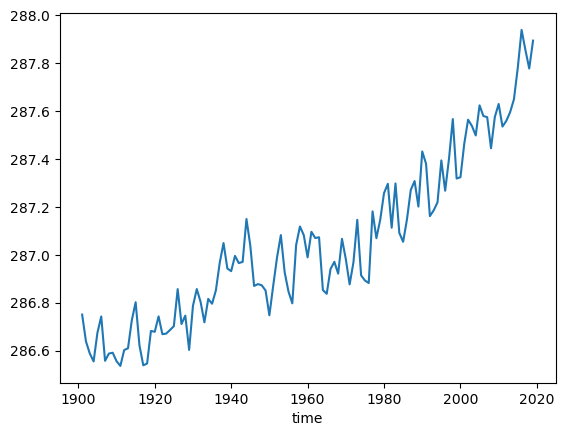

In [60]:
era_ts.plot();

In [141]:
# Data containers
nx, ny = dse.dims['lon'], dse.dims['lat']

In [142]:
df['cenlon'].min(), df['cenlon'].max(), 

(-179.92880249, 179.745834351)

In [143]:
# Nearest neighbor lookup
lon_bins = np.linspace(-180, 180, nx+1)
lat_bins = np.linspace(90, -90, ny+1)
df['lon_id'] = np.digitize(df['cenlon'], lon_bins)-1
df['lat_id'] = np.digitize(df['cenlat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
df['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(df['lon_id'], df['lat_id'])]
mdf = df.drop_duplicates(subset='unique_id').set_index('unique_id')[['rgi_region', 'rgi_subregion', 'lon_id', 'lat_id']]
mdf['area'] = df.groupby('unique_id').sum()['rgi_area_km2']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(df), len(mdf)))

Total number of glaciers: 215547 and number of W5E5 gridpoints with glaciers in them: 4695


In [144]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['area']
dse['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))
dse['glacier_area'] = (('lat', 'lon'), mask)
dse['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['rgi_region'].astype(int)
dse['rgi_region'] = (('lat', 'lon'), reg)

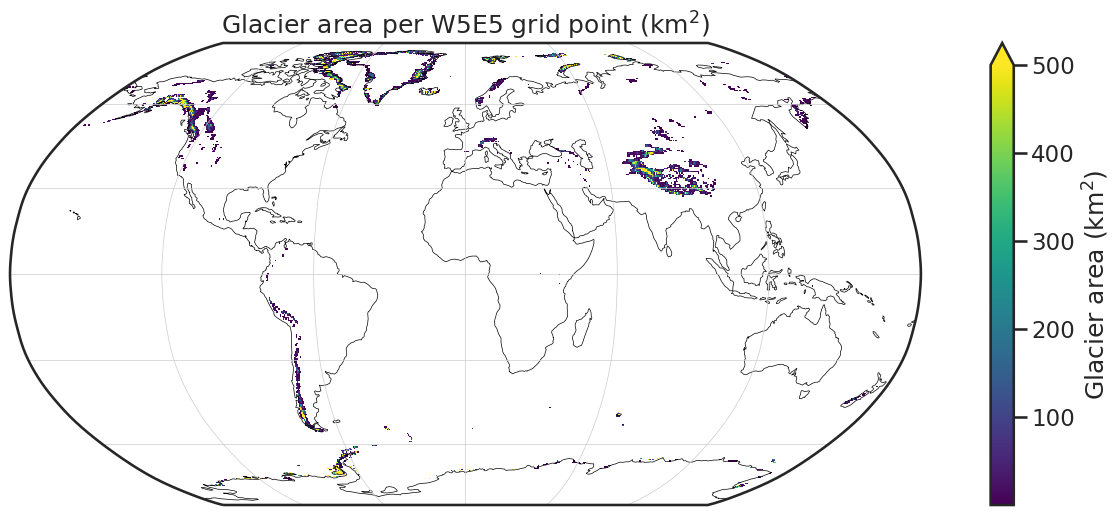

In [105]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(linewidth=0.5); ax.gridlines(linewidth=0.5); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');
    plt.savefig('area_check.pdf')

In [148]:
df['wmu'] = df['mu_star_glacierwide'] * df['rgi_area_km2']
dfs = df.loc[~df['wmu'].isnull()]
mdf['mu_star'] = dfs.groupby('unique_id').sum()['wmu'] / dfs.groupby('unique_id').sum()['rgi_area_km2']

mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['mu_star']
dse['mu_star'] = (('lat', 'lon'), mask)

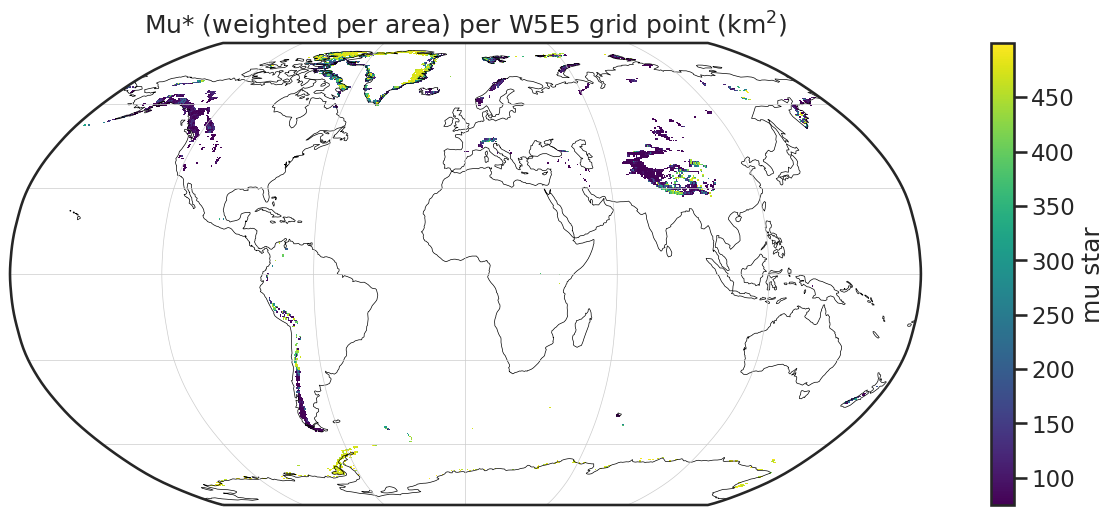

In [149]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['mu_star'].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'mu star'}) 
    ax.coastlines(linewidth=0.5); ax.gridlines(linewidth=0.5); ax.set_title('Mu* (weighted per area) per W5E5 grid point (km$^{2}$)');
    plt.savefig('mustar.pdf')

In [150]:
mdf['mu_star'].min()

75.00198150392347

In [151]:
df['tcor'] = df.ref_hgt_calib_diff * 0.0065
df['wtcor'] = df['tcor'] * df['rgi_area_km2']
dfs = df.loc[~df['wtcor'].isnull()]
mdf['tcor'] = dfs.groupby('unique_id').sum()['wtcor'] / dfs.groupby('unique_id').sum()['rgi_area_km2']

mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['tcor']
dse['tcor'] = (('lat', 'lon'), mask)

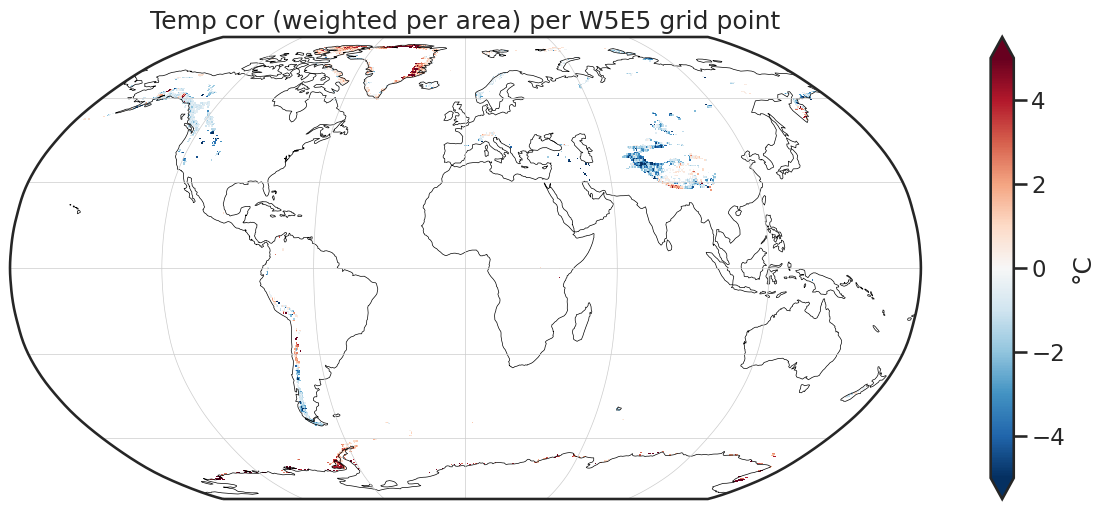

In [152]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['tcor'].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'°C'}, vmin=-5, vmax=+5, cmap='RdBu_r') 
    ax.coastlines(linewidth=0.5); ax.gridlines(linewidth=0.5); ax.set_title('Temp cor (weighted per area) per W5E5 grid point');
    plt.savefig('tcor.pdf')

In [162]:
hdf = pd.read_hdf('/home/www/oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf')

In [180]:
hdf = hdf.loc[hdf.period == '2000-01-01_2020-01-01']

In [181]:
len(hdf)

206950

In [182]:
hdf = hdf.loc[~hdf.is_cor].copy()
len(hdf)

206950

In [183]:
hdf['area_km2'] = hdf['area'] * 1e-6

In [186]:
hdf['bins'] = pd.cut(hdf['area_km2'], [0, 1, 5, 10, 100, 100000])

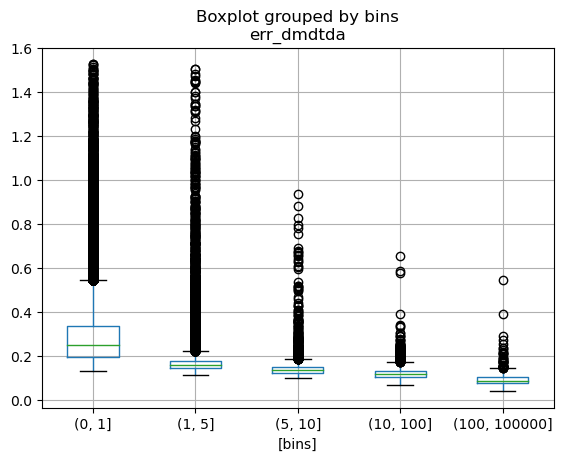

In [190]:
hdf[['bins', 'err_dmdtda']].boxplot(by='bins');

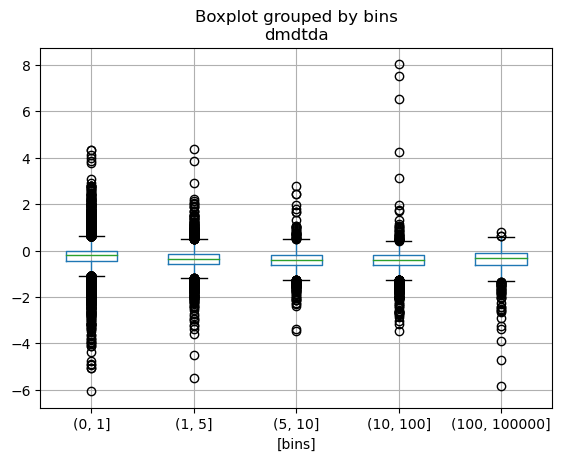

In [191]:
hdf[['bins', 'dmdtda']].boxplot(by='bins');

In [177]:
hdfb = hdf.groupby(hdf['bins']).mean()

In [178]:
hdfb['N'] = hdf.groupby(hdf['bins']).count()['err_dmdtda']

In [179]:
hdfb

area    dmdtda  err_dmdtda       reg  is_cor  \
bins                                                                  
(0, 1]         2.649617e+05 -0.259191    0.288469  9.941917     0.0   
(1, 10]        2.842805e+06 -0.366557    0.168570  8.945401     0.0   
(10, 100]      2.803904e+07 -0.436880    0.121588  7.591706     0.0   
(100, 100000]  4.024335e+08 -0.423187    0.095646  7.900312     0.0   

                 area_km2       N  
bins                               
(0, 1]           0.264962  162232  
(1, 10]          2.842805   37821  
(10, 100]       28.039040    5932  
(100, 100000]  402.433461     963

In [25]:
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon'])
lon_bins = np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of ERA5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

Total number of glaciers: 216502 and number of ERA5 gridpoints with glaciers in them: 11323


In [26]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area']
dse['glacier_mask'] = (('latitude', 'longitude'), np.isfinite(mask))
dse['glacier_area'] = (('latitude', 'longitude'), mask)
dse['weight_glacier'] = (('latitude', 'longitude'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
dse['rgi_region'] = (('latitude', 'longitude'), reg)

In [30]:
fd = f'{dd}/{exp}/cru/qc0/pcp2.5/match_geod_pergla/RGI62/b_{border:03d}/L3/summary/'
fs = glob.glob(fd+'glacier_statistics*.csv')
assert len(fs) == 18

df = []
for f in fs:
    df.append(pd.read_csv(f, index_col=0, low_memory=False))
df = pd.concat(df).sort_index()

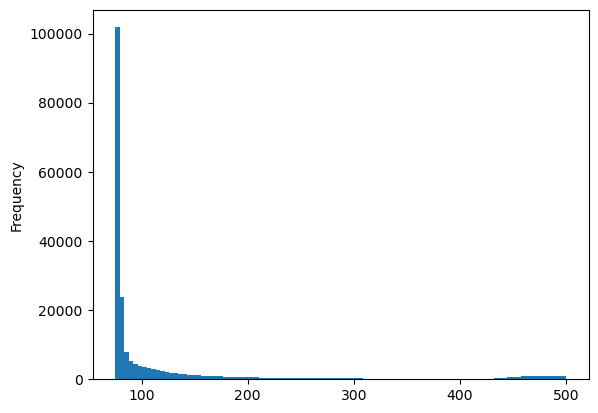

In [31]:
df.mu_star_glacierwide.plot(kind='hist', bins=100);

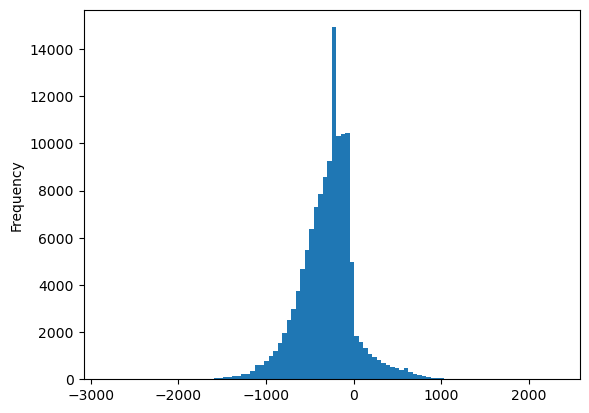

In [32]:
df.ref_hgt_calib_diff.plot(kind='hist', bins=100);

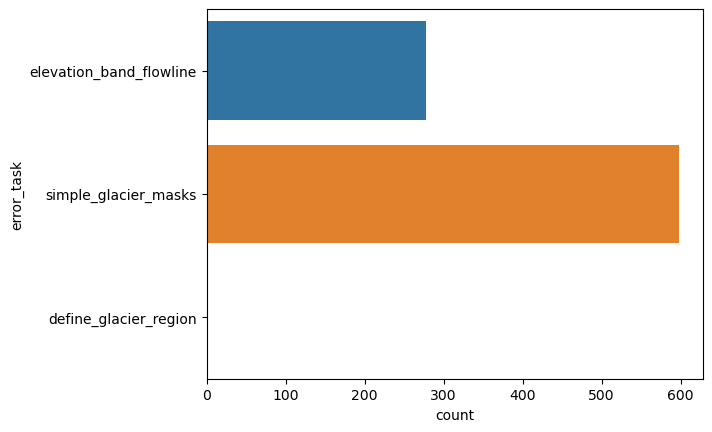

0.04852234337715137


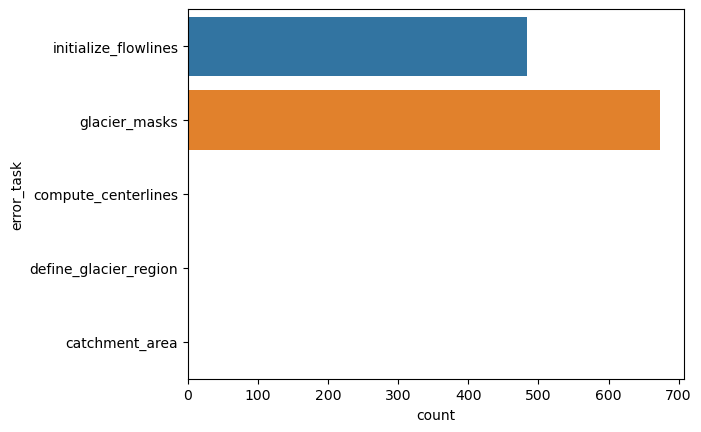

0.08247909943428476


In [3]:
dfserr = []

for exp in ['elev_bands', 'centerlines']:  # 

    fd = f'{dd}/{exp}/RGI62/b_{border:03d}/L2/summary/'
    fs = glob.glob(fd+'glacier_statistics*.csv')
    assert len(fs) == 19
    
    df = []
    for f in fs:c
        df.append(pd.read_csv(f, index_col=0, low_memory=False))
    df = pd.concat(df).sort_index()
    
    plt.figure()
    sns.countplot(y="error_task", data=df);
    plt.show()
    
    print(df.loc[~df['error_task'].isnull()].rgi_area_km2.sum() / df.rgi_area_km2.sum() * 100)
    
    dfserr.append(df.loc[~df['error_task'].isnull()].sort_values(by='rgi_area_km2', ascending=False)[['rgi_area_km2', 'error_task', 'error_msg']].iloc[:15])

In [14]:
v_eb = pd.DataFrame()
v_cl = pd.DataFrame()

var = 'volume'
# var = 'area'

for reg in range(1, 20):
    f = f'../L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla/RGI62/b_160/L5/summary/historical_run_output_extended_{reg:02d}.nc'
    ds = xr.open_dataset(f)
    
    v = ds[var].load()
    is_null = v.isel(time=-1).isnull().data
    
    f = f'../L3-L5_files/centerlines/w5e5/qc0/pcpwin/match_geod_pergla/RGI62/b_160/L5/summary/historical_run_output_extended_{reg:02d}.nc'
    
    ds = xr.open_dataset(f)
    v2 = ds[var].load()
    is_null = is_null | v2.isel(time=-1).isnull().data
    
    v = v.sel(rgi_id=~is_null)
    v2 = v2.sel(rgi_id=~is_null)
    
    v_eb[f'{reg:02d}'] = v.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-9
    v_cl[f'{reg:02d}'] = v2.sel(time=slice(2000, None)).sum(dim='rgi_id').to_series() * 1e-9

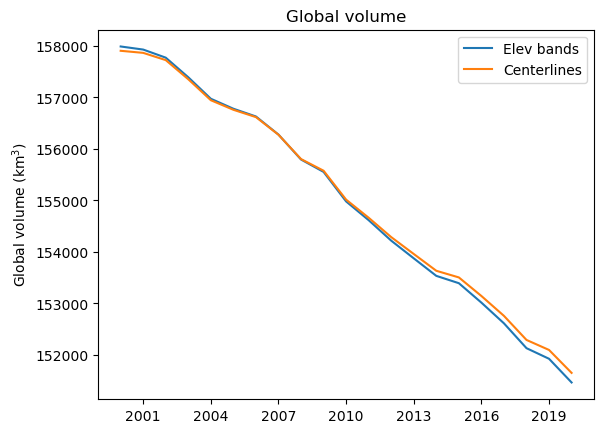

In [15]:
f, ax = plt.subplots()
v_eb.sum(axis=1).plot(ax=ax, label='Elev bands');
v_cl.sum(axis=1).plot(ax=ax, label='Centerlines');
ax.set_ylabel('Global volume (km$^3$)'); ax.set_xlabel('');
ax.legend();
plt.title('Global volume');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))